In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import scanpy as sc
import numpy as np
import scvi
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import poisson_atac as patac
from scipy.sparse import csr_matrix
from anndata import AnnData
import anndata

Global seed set to 0


In [2]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_2022.h5ad")

In [3]:
adata_atac = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_2022_ATAC.h5ad")

# Embed GEX + ATAC

Preprocess GEX data

In [4]:
adata.layers["raw_counts"] = np.round(np.exp(adata.layers["log_raw_counts"])-1)
adata.layers["counts"] = adata.layers["raw_counts"].copy()

In [5]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)


Preprocess ATAC data

In [6]:
n_peaks_before = adata_atac.shape[1]

In [7]:
sc.pp.filter_genes(adata_atac, min_cells=int(adata_atac.shape[0]*0.01))

In [8]:
print(f"filtered {n_peaks_before - adata_atac.n_vars} peaks.")

filtered 29724 peaks.


Concatenate GEX and ATAC

In [9]:
adata_multiome = anndata.concat([adata, adata_atac], axis=1, join="inner")

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [10]:
gex_set = adata.var.index
def get_feature_type(x):
    return "Gene Expression" if x["ind"] in gex_set else "Peaks"

adata_multiome.var["ind"] = adata_multiome.var.index
adata_multiome.var["feature_type"] = adata_multiome.var.apply(get_feature_type, axis=1)

del adata_multiome.var["ind"]

In [11]:
gex_counts = adata.X

In [12]:
atac_counts = adata_atac.X.copy()

In [13]:
adata_multiome.layers["counts"] = np.hstack((gex_counts.A, atac_counts.A))

In [14]:
adata_multiome

AnnData object with n_obs × n_vars = 16918 × 200535
    var: 'n_cells', 'feature_type'
    layers: 'counts'

In [15]:
adata_multiome.obs["batch_id"] = 1
adata_multiome.obs["modality"] = "paired"

In [16]:
adata_multiome.var

,n_cells,feature_type
Xkr4,1676,Gene Expression
St18,5662,Gene Expression
Sntg1,824,Gene Expression
1700034P13Rik,591,Gene Expression
Tcf24,552,Gene Expression
...,...,...
Y-90804643-90805569,1758,Peaks
Y-90807280-90808077,2446,Peaks
Y-90808486-90809311,2882,Peaks
Y-90812396-90813268,2003,Peaks


In [17]:
patac.model.MULTIVI.setup_anndata(adata_multiome, layer="counts", batch_key="modality")

In [18]:
multi_vi = patac.model.MULTIVI(adata_multiome, n_genes=(adata_multiome.var['feature_type']=='Gene Expression').sum(),
    n_regions=(adata_multiome.var['feature_type']=='Peaks').sum())


In [19]:
multi_vi.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/500:   0%|                                                                                                                           | 0/500 [00:00<?, ?it/s]

/home/icb/dominik.klein/git_repos/scatac_poisson/poisson_atac/module/_poissonmultivae.py:583: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1660070785140/work/aten/src/ATen/native/TensorShape.cpp:2981.)
  x = torch.where(mask_expr.T, x_expr.T, x_acc.T).T
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distributi

Epoch 2/500:   0%|▏                                                                                        | 1/500 [00:27<3:51:06, 27.79s/it, loss=2.29e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 3/500:   0%|▎                                                                                         | 2/500 [00:49<3:21:05, 24.23s/it, loss=2.3e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 4/500:   1%|▌                                                                                         | 3/500 [01:11<3:11:22, 23.10s/it, loss=2.3e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 5/500:   1%|▋                                                                                        | 4/500 [01:33<3:06:36, 22.57s/it, loss=2.29e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 6/500:   1%|▉                                                                                         | 5/500 [01:54<3:03:48, 22.28s/it, loss=2.3e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 7/500:   1%|█                                                                                        | 6/500 [02:16<3:01:12, 22.01s/it, loss=2.32e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 8/500:   1%|█▏                                                                                       | 7/500 [02:37<2:58:47, 21.76s/it, loss=2.24e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 9/500:   2%|█▍                                                                                       | 8/500 [02:58<2:57:05, 21.60s/it, loss=2.27e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 10/500:   2%|█▌                                                                                      | 9/500 [03:20<2:57:05, 21.64s/it, loss=2.25e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 11/500:   2%|█▋                                                                                     | 10/500 [03:42<2:57:00, 21.67s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 12/500:   2%|█▉                                                                                     | 11/500 [04:03<2:55:44, 21.56s/it, loss=2.28e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 13/500:   2%|██                                                                                     | 12/500 [04:24<2:54:38, 21.47s/it, loss=2.24e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 14/500:   3%|██▎                                                                                    | 13/500 [04:46<2:55:38, 21.64s/it, loss=2.25e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 15/500:   3%|██▍                                                                                    | 14/500 [05:09<2:56:45, 21.82s/it, loss=2.25e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 16/500:   3%|██▌                                                                                    | 15/500 [05:30<2:56:12, 21.80s/it, loss=2.24e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 17/500:   3%|██▊                                                                                    | 16/500 [05:52<2:56:08, 21.84s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 18/500:   3%|██▉                                                                                     | 17/500 [06:14<2:56:00, 21.86s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 19/500:   4%|███▏                                                                                    | 18/500 [06:36<2:55:59, 21.91s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 20/500:   4%|███▎                                                                                   | 19/500 [06:58<2:55:28, 21.89s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 21/500:   4%|███▍                                                                                   | 20/500 [07:20<2:55:11, 21.90s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 22/500:   4%|███▋                                                                                   | 21/500 [07:42<2:54:08, 21.81s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 23/500:   4%|███▊                                                                                   | 22/500 [08:03<2:53:42, 21.81s/it, loss=2.25e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 24/500:   5%|████                                                                                   | 23/500 [08:25<2:53:12, 21.79s/it, loss=2.24e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 25/500:   5%|████▏                                                                                  | 24/500 [08:47<2:53:01, 21.81s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 26/500:   5%|████▎                                                                                  | 25/500 [09:08<2:51:29, 21.66s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 27/500:   5%|████▌                                                                                  | 26/500 [09:30<2:50:40, 21.60s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 28/500:   5%|████▋                                                                                  | 27/500 [09:52<2:50:46, 21.66s/it, loss=2.26e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 29/500:   6%|████▊                                                                                  | 28/500 [10:13<2:50:49, 21.72s/it, loss=2.24e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 30/500:   6%|█████                                                                                  | 29/500 [10:35<2:49:34, 21.60s/it, loss=2.26e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 31/500:   6%|█████▏                                                                                 | 30/500 [10:57<2:50:23, 21.75s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 32/500:   6%|█████▍                                                                                 | 31/500 [11:19<2:50:16, 21.78s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 33/500:   6%|█████▌                                                                                 | 32/500 [11:40<2:49:09, 21.69s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 34/500:   7%|█████▋                                                                                 | 33/500 [12:02<2:48:05, 21.60s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 35/500:   7%|█████▉                                                                                 | 34/500 [12:23<2:48:13, 21.66s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 36/500:   7%|██████                                                                                 | 35/500 [12:45<2:48:13, 21.71s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 37/500:   7%|██████▎                                                                                | 36/500 [13:07<2:48:25, 21.78s/it, loss=2.26e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 38/500:   7%|██████▍                                                                                | 37/500 [13:29<2:48:07, 21.79s/it, loss=2.25e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 39/500:   8%|██████▌                                                                                | 38/500 [13:50<2:46:38, 21.64s/it, loss=2.19e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 40/500:   8%|██████▊                                                                                | 39/500 [14:12<2:45:29, 21.54s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 41/500:   8%|██████▉                                                                                | 40/500 [14:33<2:44:41, 21.48s/it, loss=2.18e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 42/500:   8%|███████▏                                                                               | 41/500 [14:55<2:44:46, 21.54s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 43/500:   8%|███████▎                                                                               | 42/500 [15:16<2:44:51, 21.60s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 44/500:   9%|███████▍                                                                               | 43/500 [15:38<2:45:10, 21.69s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 45/500:   9%|███████▋                                                                               | 44/500 [16:00<2:44:55, 21.70s/it, loss=2.24e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 46/500:   9%|███████▊                                                                               | 45/500 [16:21<2:44:02, 21.63s/it, loss=2.25e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 47/500:   9%|████████                                                                               | 46/500 [16:43<2:44:16, 21.71s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 48/500:   9%|████████▎                                                                               | 47/500 [17:05<2:44:23, 21.77s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 49/500:  10%|████████▎                                                                              | 48/500 [17:27<2:44:27, 21.83s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 50/500:  10%|████████▌                                                                              | 49/500 [17:49<2:44:14, 21.85s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 51/500:  10%|████████▋                                                                              | 50/500 [18:11<2:43:53, 21.85s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 52/500:  10%|████████▊                                                                              | 51/500 [18:33<2:43:34, 21.86s/it, loss=2.24e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 53/500:  10%|█████████                                                                              | 52/500 [18:55<2:43:25, 21.89s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 54/500:  11%|█████████▏                                                                             | 53/500 [19:17<2:42:53, 21.86s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 55/500:  11%|█████████▍                                                                             | 54/500 [19:38<2:42:33, 21.87s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 56/500:  11%|█████████▌                                                                             | 55/500 [20:00<2:42:04, 21.85s/it, loss=2.24e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 57/500:  11%|█████████▊                                                                              | 56/500 [20:22<2:41:16, 21.79s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 58/500:  11%|█████████▉                                                                             | 57/500 [20:43<2:40:22, 21.72s/it, loss=2.19e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 59/500:  12%|██████████                                                                             | 58/500 [21:06<2:40:54, 21.84s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 60/500:  12%|██████████▎                                                                            | 59/500 [21:27<2:40:15, 21.80s/it, loss=2.24e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 61/500:  12%|██████████▍                                                                            | 60/500 [21:49<2:39:52, 21.80s/it, loss=2.25e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 62/500:  12%|██████████▋                                                                             | 61/500 [22:11<2:40:05, 21.88s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 63/500:  12%|██████████▉                                                                             | 62/500 [22:33<2:39:45, 21.88s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 64/500:  13%|██████████▉                                                                            | 63/500 [22:55<2:38:41, 21.79s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 65/500:  13%|███████████▏                                                                           | 64/500 [23:17<2:38:49, 21.86s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 66/500:  13%|███████████▎                                                                           | 65/500 [23:39<2:38:31, 21.87s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 67/500:  13%|███████████▍                                                                           | 66/500 [24:00<2:37:57, 21.84s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 68/500:  13%|███████████▋                                                                           | 67/500 [24:22<2:36:36, 21.70s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 69/500:  14%|███████████▊                                                                           | 68/500 [24:43<2:35:32, 21.60s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 70/500:  14%|████████████▏                                                                           | 69/500 [25:04<2:34:42, 21.54s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 71/500:  14%|████████████▎                                                                           | 70/500 [25:26<2:33:59, 21.49s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 72/500:  14%|████████████▎                                                                          | 71/500 [25:47<2:33:19, 21.44s/it, loss=2.19e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 73/500:  14%|████████████▌                                                                          | 72/500 [26:09<2:32:51, 21.43s/it, loss=2.18e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 74/500:  15%|████████████▋                                                                          | 73/500 [26:30<2:32:23, 21.41s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 75/500:  15%|████████████▉                                                                          | 74/500 [26:51<2:31:57, 21.40s/it, loss=2.24e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 76/500:  15%|█████████████                                                                          | 75/500 [27:13<2:31:46, 21.43s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 77/500:  15%|█████████████▏                                                                         | 76/500 [27:34<2:31:18, 21.41s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 78/500:  15%|█████████████▍                                                                         | 77/500 [27:56<2:32:04, 21.57s/it, loss=2.24e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 79/500:  16%|█████████████▋                                                                          | 78/500 [28:18<2:32:21, 21.66s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 80/500:  16%|█████████████▋                                                                         | 79/500 [28:40<2:32:19, 21.71s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 81/500:  16%|█████████████▉                                                                         | 80/500 [29:02<2:32:23, 21.77s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 82/500:  16%|██████████████                                                                         | 81/500 [29:24<2:32:19, 21.81s/it, loss=2.19e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 83/500:  16%|██████████████▎                                                                        | 82/500 [29:46<2:32:06, 21.83s/it, loss=2.24e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 84/500:  17%|██████████████▌                                                                         | 83/500 [30:08<2:32:27, 21.94s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 85/500:  17%|██████████████▌                                                                        | 84/500 [30:30<2:31:58, 21.92s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 86/500:  17%|██████████████▊                                                                        | 85/500 [30:51<2:31:22, 21.88s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 87/500:  17%|██████████████▉                                                                        | 86/500 [31:13<2:30:05, 21.75s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 88/500:  17%|███████████████▏                                                                       | 87/500 [31:34<2:28:54, 21.63s/it, loss=2.19e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 89/500:  18%|███████████████▎                                                                       | 88/500 [31:56<2:27:56, 21.54s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 90/500:  18%|███████████████▍                                                                       | 89/500 [32:17<2:27:10, 21.49s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 91/500:  18%|███████████████▊                                                                        | 90/500 [32:38<2:26:29, 21.44s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 92/500:  18%|███████████████▊                                                                       | 91/500 [33:00<2:26:09, 21.44s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 93/500:  18%|████████████████▏                                                                       | 92/500 [33:21<2:26:30, 21.55s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 94/500:  19%|████████████████▏                                                                      | 93/500 [33:43<2:26:33, 21.61s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 95/500:  19%|████████████████▎                                                                      | 94/500 [34:05<2:26:03, 21.59s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 96/500:  19%|████████████████▌                                                                      | 95/500 [34:26<2:25:46, 21.60s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 97/500:  19%|████████████████▋                                                                      | 96/500 [34:48<2:24:44, 21.50s/it, loss=2.19e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 98/500:  19%|█████████████████                                                                       | 97/500 [35:09<2:24:53, 21.57s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 99/500:  20%|█████████████████▏                                                                      | 98/500 [35:31<2:25:16, 21.68s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 100/500:  20%|█████████████████                                                                     | 99/500 [35:53<2:25:08, 21.72s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 101/500:  20%|█████████████████                                                                    | 100/500 [36:15<2:24:48, 21.72s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 102/500:  20%|█████████████████▏                                                                   | 101/500 [36:37<2:24:34, 21.74s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 103/500:  20%|█████████████████▎                                                                   | 102/500 [36:58<2:23:55, 21.70s/it, loss=2.18e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 104/500:  21%|█████████████████▋                                                                    | 103/500 [37:20<2:23:01, 21.62s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 105/500:  21%|█████████████████▋                                                                   | 104/500 [37:41<2:22:27, 21.59s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 106/500:  21%|█████████████████▊                                                                   | 105/500 [38:02<2:21:30, 21.50s/it, loss=2.19e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 107/500:  21%|██████████████████▏                                                                   | 106/500 [38:24<2:20:54, 21.46s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 108/500:  21%|██████████████████▏                                                                  | 107/500 [38:45<2:20:06, 21.39s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 109/500:  22%|██████████████████▎                                                                  | 108/500 [39:06<2:19:21, 21.33s/it, loss=2.24e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 110/500:  22%|██████████████████▌                                                                  | 109/500 [39:27<2:18:47, 21.30s/it, loss=2.19e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 111/500:  22%|██████████████████▋                                                                  | 110/500 [39:49<2:19:09, 21.41s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 112/500:  22%|██████████████████▊                                                                  | 111/500 [40:11<2:19:35, 21.53s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 113/500:  22%|███████████████████                                                                  | 112/500 [40:33<2:20:14, 21.69s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 114/500:  23%|███████████████████▏                                                                 | 113/500 [40:55<2:19:54, 21.69s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 115/500:  23%|███████████████████▍                                                                 | 114/500 [41:17<2:20:19, 21.81s/it, loss=2.19e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 116/500:  23%|███████████████████▌                                                                 | 115/500 [41:39<2:19:58, 21.81s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 117/500:  23%|███████████████████▋                                                                 | 116/500 [42:00<2:19:31, 21.80s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 118/500:  23%|███████████████████▉                                                                 | 117/500 [42:22<2:19:36, 21.87s/it, loss=2.24e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 119/500:  24%|████████████████████                                                                 | 118/500 [42:44<2:19:20, 21.89s/it, loss=2.19e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 120/500:  24%|████████████████████▏                                                                | 119/500 [43:06<2:18:44, 21.85s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 121/500:  24%|████████████████████▍                                                                | 120/500 [43:28<2:18:12, 21.82s/it, loss=2.24e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 122/500:  24%|████████████████████▌                                                                | 121/500 [43:50<2:17:35, 21.78s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 123/500:  24%|████████████████████▋                                                                | 122/500 [44:11<2:16:51, 21.72s/it, loss=2.19e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 124/500:  25%|█████████████████████▏                                                                | 123/500 [44:33<2:16:32, 21.73s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 125/500:  25%|█████████████████████                                                                | 124/500 [44:55<2:16:26, 21.77s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 126/500:  25%|█████████████████████▎                                                               | 125/500 [45:17<2:16:50, 21.90s/it, loss=2.16e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 127/500:  25%|█████████████████████▍                                                               | 126/500 [45:39<2:16:26, 21.89s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 128/500:  25%|█████████████████████▌                                                               | 127/500 [46:01<2:16:04, 21.89s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 129/500:  26%|█████████████████████▊                                                               | 128/500 [46:22<2:15:26, 21.85s/it, loss=2.16e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 130/500:  26%|█████████████████████▉                                                               | 129/500 [46:44<2:15:06, 21.85s/it, loss=2.17e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 131/500:  26%|██████████████████████                                                               | 130/500 [47:06<2:14:41, 21.84s/it, loss=2.24e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 132/500:  26%|██████████████████████▎                                                              | 131/500 [47:28<2:14:15, 21.83s/it, loss=2.18e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 133/500:  26%|██████████████████████▍                                                              | 132/500 [47:50<2:13:53, 21.83s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 134/500:  27%|██████████████████████▉                                                               | 133/500 [48:12<2:13:28, 21.82s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 135/500:  27%|██████████████████████▊                                                              | 134/500 [48:33<2:13:11, 21.84s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 136/500:  27%|██████████████████████▉                                                              | 135/500 [48:55<2:12:43, 21.82s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 137/500:  27%|███████████████████████                                                              | 136/500 [49:17<2:12:12, 21.79s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 138/500:  27%|███████████████████████▎                                                             | 137/500 [49:39<2:11:44, 21.77s/it, loss=2.25e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 139/500:  28%|███████████████████████▍                                                             | 138/500 [50:00<2:11:23, 21.78s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 140/500:  28%|███████████████████████▋                                                             | 139/500 [50:22<2:11:06, 21.79s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 141/500:  28%|███████████████████████▊                                                             | 140/500 [50:44<2:10:56, 21.82s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 142/500:  28%|███████████████████████▉                                                             | 141/500 [51:06<2:10:25, 21.80s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 143/500:  28%|████████████████████████▏                                                            | 142/500 [51:28<2:10:11, 21.82s/it, loss=2.18e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 144/500:  29%|████████████████████████▎                                                            | 143/500 [51:50<2:09:44, 21.81s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 145/500:  29%|████████████████████████▍                                                            | 144/500 [52:11<2:09:17, 21.79s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 146/500:  29%|████████████████████████▉                                                             | 145/500 [52:33<2:09:25, 21.87s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 147/500:  29%|████████████████████████▊                                                            | 146/500 [52:55<2:08:55, 21.85s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 148/500:  29%|████████████████████████▉                                                            | 147/500 [53:17<2:07:54, 21.74s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 149/500:  30%|█████████████████████████▏                                                           | 148/500 [53:38<2:06:46, 21.61s/it, loss=2.19e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 150/500:  30%|█████████████████████████▎                                                           | 149/500 [53:59<2:05:51, 21.52s/it, loss=2.24e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 151/500:  30%|█████████████████████████▊                                                            | 150/500 [54:21<2:06:11, 21.63s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 152/500:  30%|█████████████████████████▉                                                            | 151/500 [54:43<2:06:14, 21.70s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 153/500:  30%|█████████████████████████▊                                                           | 152/500 [55:05<2:06:00, 21.73s/it, loss=2.21e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 154/500:  31%|██████████████████████████                                                           | 153/500 [55:27<2:05:44, 21.74s/it, loss=2.22e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 155/500:  31%|██████████████████████████▏                                                          | 154/500 [55:48<2:04:47, 21.64s/it, loss=2.19e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 156/500:  31%|██████████████████████████▎                                                          | 155/500 [56:10<2:04:26, 21.64s/it, loss=2.17e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 157/500:  31%|██████████████████████████▌                                                          | 156/500 [56:31<2:03:37, 21.56s/it, loss=2.18e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 158/500:  31%|██████████████████████████▋                                                          | 157/500 [56:53<2:03:45, 21.65s/it, loss=2.23e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 159/500:  32%|███████████████████████████▏                                                          | 158/500 [57:15<2:03:45, 21.71s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 160/500:  32%|███████████████████████████▎                                                          | 159/500 [57:37<2:03:42, 21.77s/it, loss=2.2e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 161/500:  32%|███████████████████████████▏                                                         | 160/500 [57:58<2:03:22, 21.77s/it, loss=2.19e+04, v_num=1]

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 161/500:  32%|███████████████████████████▎                                                         | 161/500 [58:20<2:02:51, 21.74s/it, loss=2.25e+04, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 44441.645. Signaling Trainer to stop.


In [20]:
multi_vi

MultiVI Model with INPUTS: n_genes:2000, n_regions:198535
n_hidden: 447, n_latent: 21, n_layers_encoder: 2, n_layers_decoder: 2 , dropout_rate: 0.1, 
latent_distribution: normal, deep injection: False, gene_likelihood: zinb, peak_likelihood: 
poisson
Training status: Trained

<AxesSubplot:xlabel='epoch', ylabel='kl_global_train'>

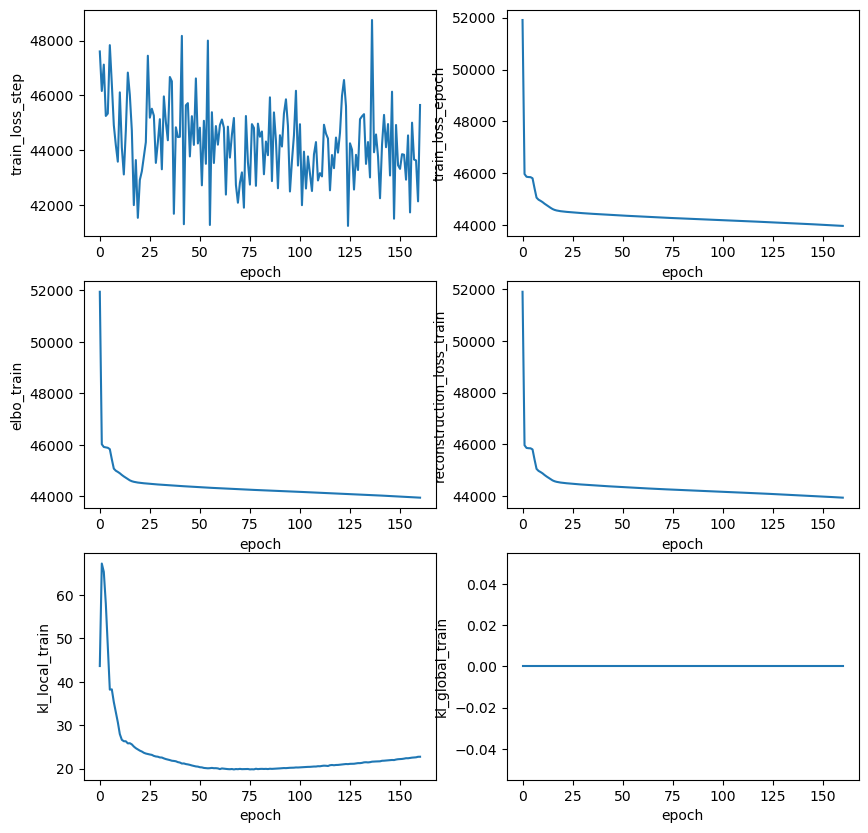

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

sns.lineplot(data=multi_vi.history['train_loss_step'], x="epoch", y="train_loss_step", ax=axs[0][0])
sns.lineplot(data=multi_vi.history['train_loss_epoch'], x="epoch", y="train_loss_epoch", ax=axs[0][1])
sns.lineplot(data=multi_vi.history['elbo_train'], x="epoch", y="elbo_train", ax=axs[1][0])
sns.lineplot(data=multi_vi.history['reconstruction_loss_train'], x="epoch", y='reconstruction_loss_train', ax=axs[1][1])
sns.lineplot(data=multi_vi.history['kl_local_train'], x="epoch", y='kl_local_train', ax=axs[2][0])
sns.lineplot(data=multi_vi.history['kl_global_train'], x="epoch", y='kl_global_train', ax=axs[2][1])

In [22]:
adata_multiome.obsm["X_multi_vi"]=multi_vi.get_latent_representation()

In [23]:
adata_multiome.obs["celltype"] = adata.obs["celltype"]

In [36]:
#adata_multi.obsm["X_multi_vi_pca"] = sc.pp.pca(adata.obsm["X_multi_vi"])

In [28]:
adata_multiome.obs["sample"] = adata.obs["sample"]

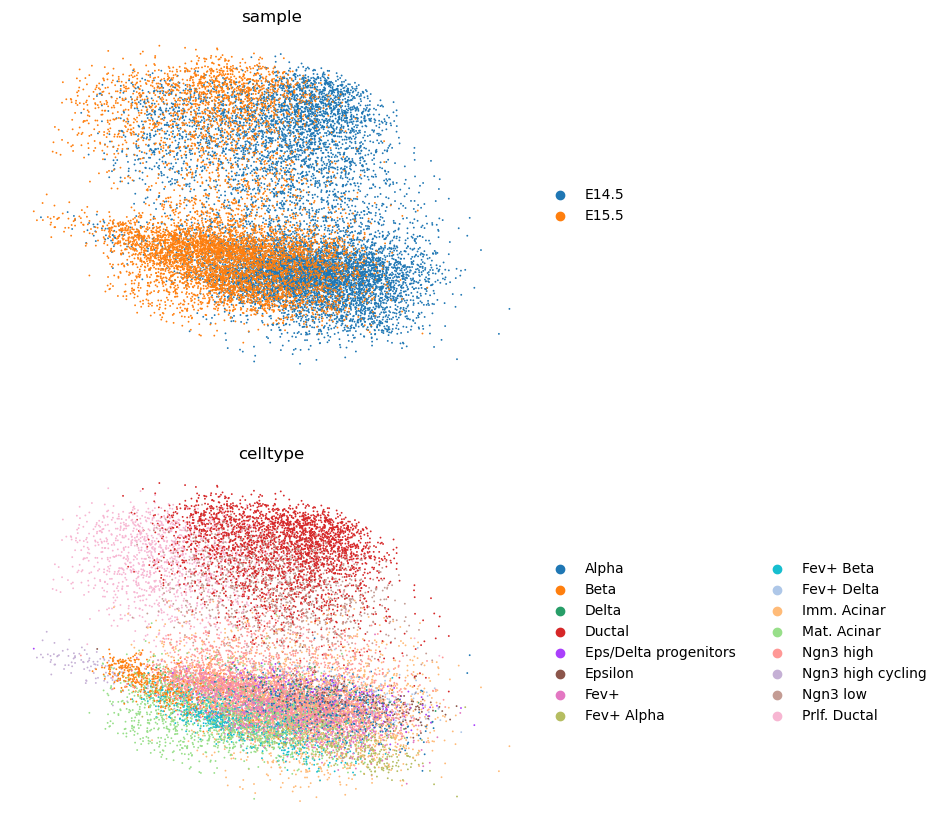

In [29]:
sc.pl.embedding(
    adata_multiome,
    basis="X_multi_vi",
    color=["sample", "celltype"],
    frameon=False,
    ncols=1,
)

In [30]:
sc.pp.neighbors(adata_multiome, use_rep="X_multi_vi", key_added="multi_vi")


In [32]:
sc.tl.umap(adata_multiome, neighbors_key="multi_vi")

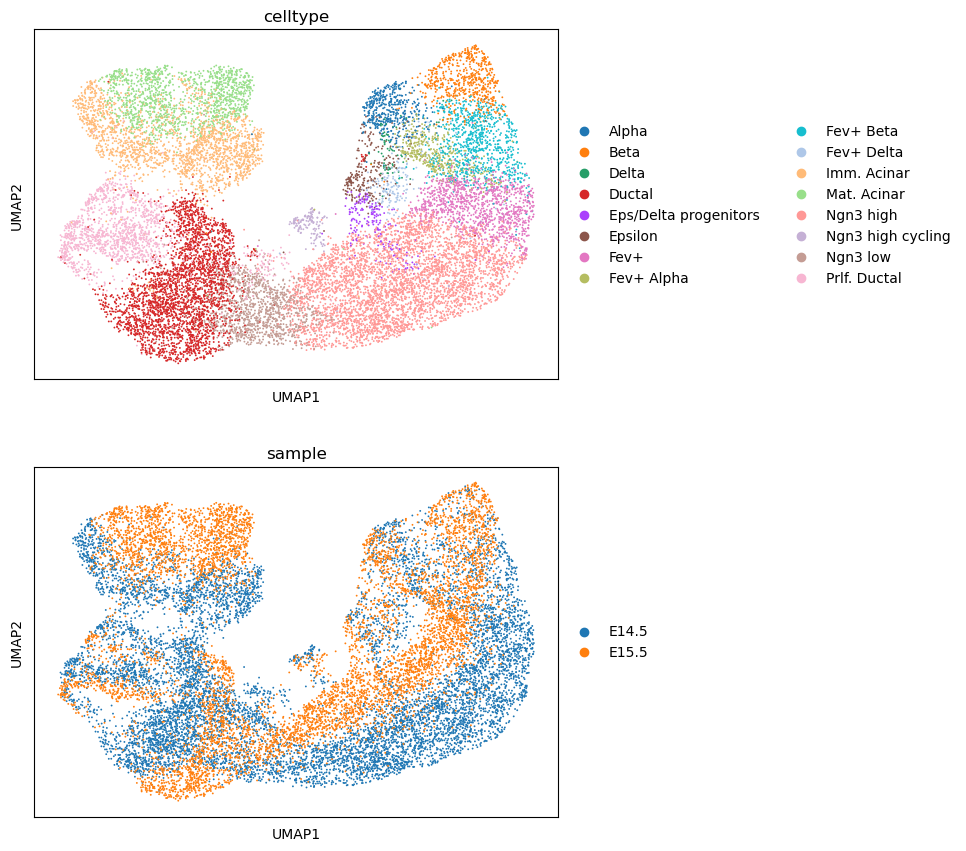

In [34]:
sc.pl.umap(adata_multiome, color=["celltype", "sample"], ncols=1)

In [35]:
adata_multiome.write("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_multiVI_embedding.h5ad")

In [36]:
multi_vi.save("/lustre/groups/ml01/workspace/moscot_paper/pancreas/models/MultiVI", overwrite=False, save_anndata=True)